# Analyzing a Social Media Network using GNN

# 1. Import required Libraries and Dataset

In [1]:
# Import required libraries
import torch
import torch.nn as nn

from torch_geometric.datasets import KarateClub
from torch_geometric.utils import to_networkx
from torch_geometric.nn import GCNConv

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Load the Karate Club Dataset
dataset = KarateClub()
data = dataset[0]
print(dataset.num_features)

34


In [3]:
print(data.x.shape) # data.x represents the node feature matrix
print(data.edge_index)

torch.Size([34, 34])
tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,
          3,  3,  3,  3,  3,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  7,  7,
          7,  7,  8,  8,  8,  8,  8,  9,  9, 10, 10, 10, 11, 12, 12, 13, 13, 13,
         13, 13, 14, 14, 15, 15, 16, 16, 17, 17, 18, 18, 19, 19, 19, 20, 20, 21,
         21, 22, 22, 23, 23, 23, 23, 23, 24, 24, 24, 25, 25, 25, 26, 26, 27, 27,
         27, 27, 28, 28, 28, 29, 29, 29, 29, 30, 30, 30, 30, 31, 31, 31, 31, 31,
         31, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 33, 33, 33, 33, 33,
         33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33],
        [ 1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 17, 19, 21, 31,  0,  2,
          3,  7, 13, 17, 19, 21, 30,  0,  1,  3,  7,  8,  9, 13, 27, 28, 32,  0,
          1,  2,  7, 12, 13,  0,  6, 10,  0,  6, 10, 16,  0,  4,  5, 16,  0,  1,
          2,  3,  0,  2, 30, 3

# 2. Data Preprocessing

In [5]:
# 1. Convert node features to a pandas DataFrame
# 'data.x' is a PyTorch tensor containing node features.
features = pd.DataFrame(data.x.numpy(), columns=[f'feature_{i}' for i in range(data.x.shape[1])])
features['node'] = features.index # Creates a new column called "node" that stores the index values (which correspond to node IDs).
features.set_index('node', inplace=True) # Sets the "node" column as the new index of the DataFrame.


# 2. Convert edge indices to a pandas DataFrame
# Represents the connections (relationships) between nodes in the graph.
edge_index = pd.DataFrame(data.edge_index.numpy().T, columns=['source', 'target'])
# print(edge_index)

# 3. Convert labels to a pandas DataFrame
# Represents the ground truth labels of nodes (for supervised learning tasks). Used for node classification problems.
labels = pd.DataFrame(data.y.numpy(), columns=['label'])
labels['node'] = labels.index
labels.set_index('node', inplace=True)

In [6]:
print(features)

      feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
node                                                                     
0           1.0        0.0        0.0        0.0        0.0        0.0   
1           0.0        1.0        0.0        0.0        0.0        0.0   
2           0.0        0.0        1.0        0.0        0.0        0.0   
3           0.0        0.0        0.0        1.0        0.0        0.0   
4           0.0        0.0        0.0        0.0        1.0        0.0   
5           0.0        0.0        0.0        0.0        0.0        1.0   
6           0.0        0.0        0.0        0.0        0.0        0.0   
7           0.0        0.0        0.0        0.0        0.0        0.0   
8           0.0        0.0        0.0        0.0        0.0        0.0   
9           0.0        0.0        0.0        0.0        0.0        0.0   
10          0.0        0.0        0.0        0.0        0.0        0.0   
11          0.0        0.0        0.0 

In [8]:
# Print the number of nodes
num_nodes = data.num_nodes
print(f"Number of nodes: {num_nodes}")

# Print the number of edges
num_edges = data.edge_index.shape[1]
print(f"Number of edges: {num_edges}")

Number of nodes: 34
Number of edges: 156


In [14]:
# Number of countries
num_countries = 4

# Assign students to countries (labels)
np.random.seed(42)  # For reproducibility
countries = torch.tensor(np.random.choice(num_countries, data.num_nodes))
# print(countries)

# Update the labels in the data object
data.y = countries

tensor([2, 3, 0, 2, 2, 3, 0, 0, 2, 1, 2, 2, 2, 2, 3, 0, 3, 3, 3, 2, 1, 0, 1, 3,
        3, 1, 1, 1, 3, 3, 0, 0, 3, 1])


# 3. Vizualize the Graph

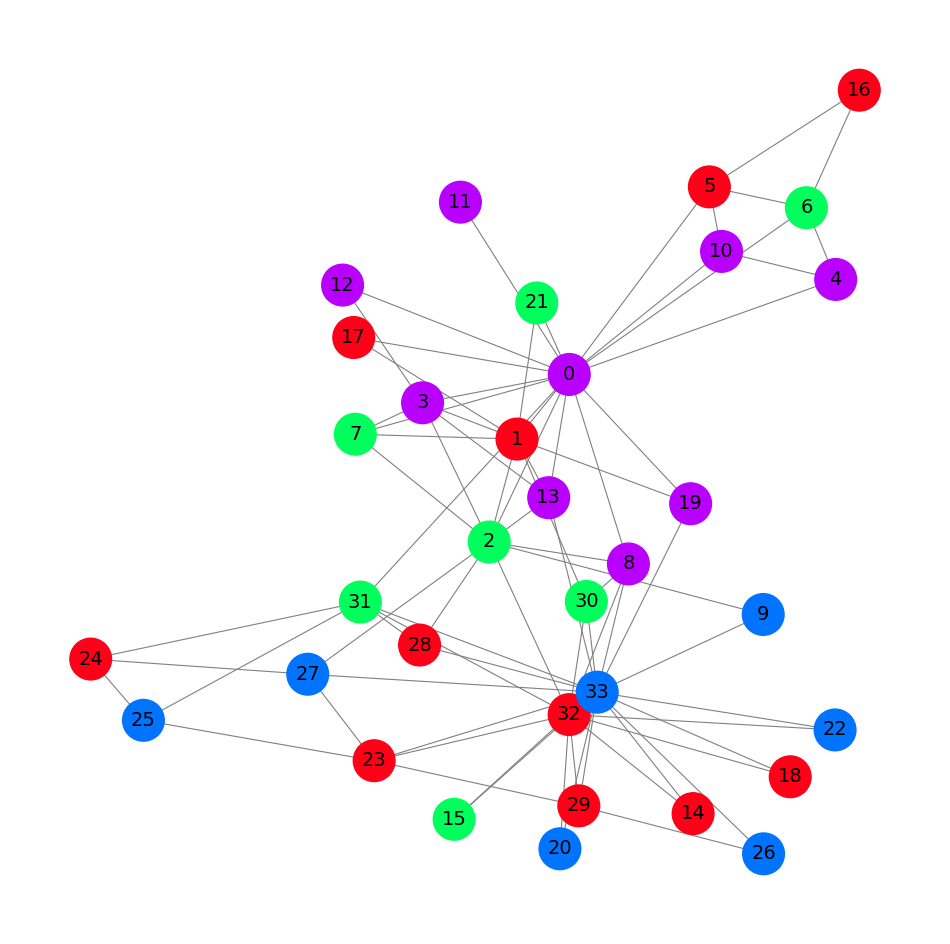

In [20]:
# Check if the graph is as expected
G = to_networkx(data, to_undirected=True)
plt.figure(figsize=(12,12))
plt.axis('off')
nx.draw_networkx(G,
                pos=nx.spring_layout(G, seed=0),
                with_labels=True,
                node_size=900,
                node_color=data.y, # 4 colors
                cmap="hsv",
                vmin=-2,
                vmax=3,
                width=0.8,
                edge_color="grey",
                font_size=14
                )
plt.show()

# 4. Define the Model

In [22]:
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.gcn = GCNConv(dataset.num_features, 3) #(34, 3)
        self.out = nn.Linear(3, num_countries)
    
    def forward(self, x, edge_index):
        h = self.gcn(x, edge_index).relu()
        z = self.out(h)
        return h, z

model = GCN()
print(model)

GCN(
  (gcn): GCNConv(34, 3)
  (out): Linear(in_features=3, out_features=4, bias=True)
)


In [23]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.02)

# Calculate accuracy
def accuracy(pred_y, y):
    return (pred_y == y).sum() / len(y)

In [24]:
# Data for animations
embeddings = []
losses = []
accuracies = []
outputs = []

# Training loop
for epoch in range(200):
    optimizer.zero_grad() # Clears Gradients
    h, z = model(data.x, data.edge_index) # Forward pass: Get node embeddings (h) and predictions (z)
    loss = criterion(z, data.y)  # Compute loss between predictions and actual labels
    acc = accuracy(z.argmax(dim=1), data.y)
    
    loss.backward()
    optimizer.step()
    
    embeddings.append(h)
    losses.append(loss)
    accuracies.append(acc)
    outputs.append(z.argmax(dim=1))
    if epoch % 10 == 0:
        print(f'Epoch {epoch:>3} | Loss: {loss:.2f} | Acc: {acc*100:.2f}%')

Epoch   0 | Loss: 1.39 | Acc: 32.35%
Epoch  10 | Loss: 1.33 | Acc: 32.35%
Epoch  20 | Loss: 1.22 | Acc: 64.71%
Epoch  30 | Loss: 1.06 | Acc: 67.65%
Epoch  40 | Loss: 0.88 | Acc: 70.59%
Epoch  50 | Loss: 0.73 | Acc: 70.59%
Epoch  60 | Loss: 0.61 | Acc: 76.47%
Epoch  70 | Loss: 0.51 | Acc: 79.41%
Epoch  80 | Loss: 0.43 | Acc: 91.18%
Epoch  90 | Loss: 0.35 | Acc: 91.18%
Epoch 100 | Loss: 0.28 | Acc: 97.06%
Epoch 110 | Loss: 0.22 | Acc: 97.06%
Epoch 120 | Loss: 0.18 | Acc: 97.06%
Epoch 130 | Loss: 0.14 | Acc: 97.06%
Epoch 140 | Loss: 0.12 | Acc: 97.06%
Epoch 150 | Loss: 0.10 | Acc: 97.06%
Epoch 160 | Loss: 0.08 | Acc: 100.00%
Epoch 170 | Loss: 0.07 | Acc: 100.00%
Epoch 180 | Loss: 0.06 | Acc: 100.00%
Epoch 190 | Loss: 0.05 | Acc: 100.00%


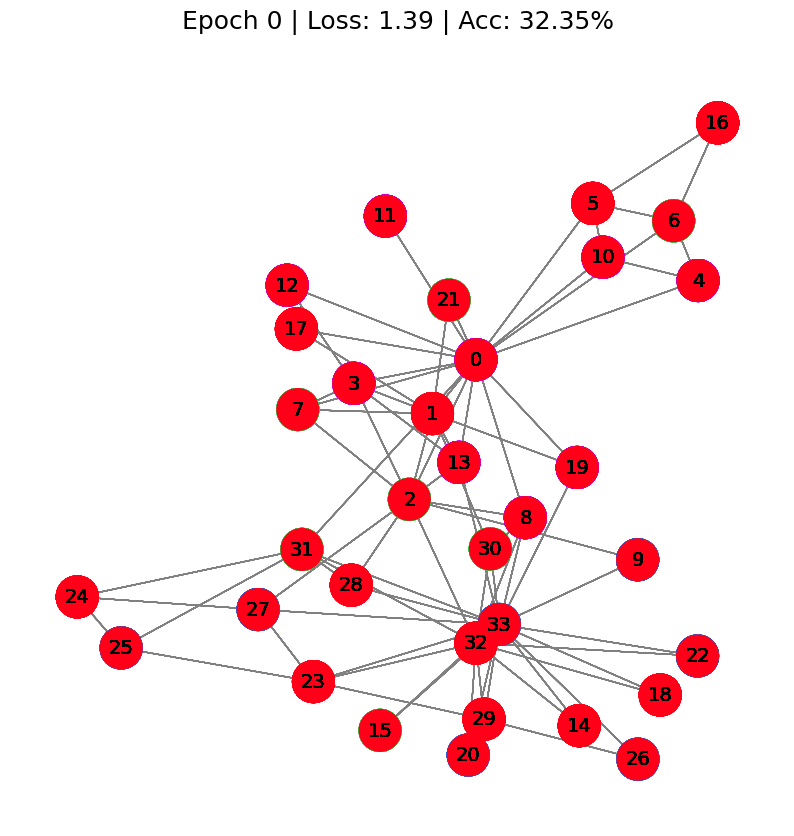

In [27]:
from IPython.display import HTML
from matplotlib import animation

plt.rcParams["animation.bitrate"] = 3000

def animate(i):
    G = to_networkx(data, to_undirected=True)
    nx.draw_networkx(G,
                    pos=nx.spring_layout(G, seed=0),
                    with_labels=True,
                    node_size=900,
                    node_color=outputs[i].numpy(),
                    cmap="hsv",
                    vmin=-2,
                    vmax=3,
                    width=0.8,
                    edge_color="grey",
                    font_size=14
                    )
    plt.title(f'Epoch {i} | Loss: {losses[i].item():.2f} | Acc: {accuracies[i].item()*100:.2f}%',
              fontsize=18, pad=20)

fig = plt.figure(figsize=(10, 10))
plt.axis('off')

anim = animation.FuncAnimation(fig, animate, np.arange(0, 200, 10), interval=500, repeat=True)
html = HTML(anim.to_html5_video())
display(html)